In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from psmiles import PolymerSmiles as PS
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
random_seed = 123
torch.manual_seed(random_seed)
np.random.seed(random_seed)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
df = pd.read_pickle("../../data/updated_polymers.pth")

In [3]:
scalar = MinMaxScaler()
data = df["fingerprint_circular"]
target = df["Egc"]

#data = data.values.reshape(-1, 1)  # Reshape data

data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.2, random_state=123)

# Scaling target variable
target_train = scalar.fit_transform(target_train.values.reshape(-1, 1))
target_test = scalar.transform(target_test.values.reshape(-1, 1))

# Creating tensors from data

#Training Data
data_train_tensor = torch.tensor(data_train.reset_index(drop = True), dtype=torch.float32)
target_train_tensor = torch.tensor(target_train, dtype=torch.float32)

train_dataset = TensorDataset(data_train_tensor, target_train_tensor)
train_loader = DataLoader(train_dataset, batch_size= 32, shuffle= True)

#Testing Data

data_test_tensor = torch.tensor(data_test.reset_index(drop= True), dtype=torch.float32)
target_test_tensor = torch.tensor(target_test, dtype=torch.float32)

test_dataset = TensorDataset(data_test_tensor, target_test_tensor)
test_loader = DataLoader(test_dataset, shuffle= False)

/tmp/ipykernel_2802639/2142380390.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  data_train_tensor = torch.tensor(data_train.reset_index(drop = True), dtype=torch.float32)


In [4]:
class MTmodel(nn.Module):
    def __init__(self):
        super(MTmodel, self).__init__()
        self.my_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(2048, 1888),
                nn.Dropout(0.296708814),
                nn.PReLU()
            ),
            nn.Sequential(
                nn.Linear(1888, 416),
                nn.Dropout(0.103316943),
                nn.PReLU()
            ),
            nn.Sequential(
                nn.Linear(416, 1632),
                nn.Dropout(0.178598433),
                nn.PReLU()
            ),
            
            nn.Linear(1632, 1)
        ])
        #self.float()
    
    def forward(self, x):
        for layer_step in self.my_layers:
            x = layer_step(x)
        return x

In [5]:

state_dict = torch.load('../../models/molecule_circular.pth')

In [6]:
net = MTmodel()
net.load_state_dict(state_dict, strict=False)
net = net.to(DEVICE)

optimizer = optim.Adam(net.parameters(), lr =  0.000364567)


EPOCHS = 98
losses = []
for epoch in range(EPOCHS):
  running_loss = 0.0
  correct = 0
  for batch_idx,(data, target) in enumerate(train_loader):

    data, target = data.to(DEVICE), target.view(-1).to(DEVICE)
    optimizer.zero_grad()
    output = net(data)
    loss = F.mse_loss(output.view(-1), target)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  epoch_loss = running_loss / batch_idx
  losses.append(epoch_loss)

  # Print epoch loss
  #print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss}")

print(losses)
#torch.save(net.state_dict(),'../../models/fine_tuning_circular_lr_no_freeze.pth')
# Plot the loss
#plt.plot(losses)
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.title('Training Loss')
#plt.show()

[0.014215310564309004, 0.007660016899795404, 0.005995700166316792, 0.00422558217958015, 0.003134936002814876, 0.0026136188715186323, 0.0021811189030164053, 0.0018696354964049533, 0.0015929483065736435, 0.0013563625259502303, 0.0013084519076593487, 0.0011852539485386973, 0.0013084078836116185, 0.001122708274037688, 0.0010472717722656117, 0.0009208420267982763, 0.0008988304509243573, 0.0009185279833175065, 0.0007857263955797645, 0.0007535741848793501, 0.0007157251872870672, 0.0007203087637511393, 0.0006425125341463302, 0.0006330962101596274, 0.0007998276593016705, 0.0007360289181676871, 0.0006909519229555458, 0.0006224912691063114, 0.0005747350376276742, 0.0005962307725331769, 0.000548832251384045, 0.0006118511465458488, 0.0005387455317499448, 0.0005991241873527455, 0.0005627517493849155, 0.0005525596047629646, 0.0005229487123003873, 0.0005104415817879184, 0.00048257429045320136, 0.00046914295533150875, 0.00048141588056404584, 0.00045450429717588817, 0.0004510438820510726, 0.000507728050

mse: 0.30781871544889905, rmse: 0.5548141269370301, r2_score: 0.8529854466107143


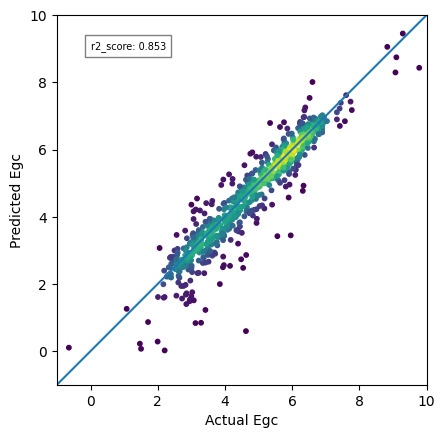

In [7]:




from scipy.stats import gaussian_kde

# Plot predictions vs. true values
@torch.no_grad()
def graphPredictions(model, data_loader , minValue, maxValue):
    
    model.eval()                               # Set the model to inference mode

    predictions=[]                             # Track predictions
    actual=[]                                  # Track the actual labels
    model = model.to(DEVICE)
    loss = []
    

    for (data,target) in (test_loader):
        # Single forward pass
        data, target =  data.to(DEVICE), target.to(DEVICE)
        pred = model(data)                              
        
        # Un-normalize our prediction
        pred = scalar.inverse_transform(pred.cpu().numpy())
        pred = torch.from_numpy(pred).to(DEVICE)
        target_cpu = scalar.inverse_transform(target.cpu().numpy())
        act = torch.from_numpy(target_cpu).to(DEVICE)
        loss = F.mse_loss(pred, act)

        # Save prediction and actual label
        predictions.append(tensor.cpu().item() for tensor in pred)
        actual.append(tensor.cpu().item() for tensor in act)


    #print(f"predictions: {predictions}, actual: {actual}")
    pred_list = [item for sublist in predictions for item in sublist]
    act_list = [item for sublist in actual for item in sublist]

    
    mse = mean_squared_error(pred_list, act_list)
    rmse = mean_squared_error(pred_list, act_list, squared = False)
    r2 = r2_score(pred_list, act_list)
    print(f"mse: {mse}, rmse: {rmse}, r2_score: {r2}")

    # Calculate the point density
    xy = np.vstack([pred_list,act_list])
    z = gaussian_kde(xy)(xy)
    
    # Plot actuals vs predictions
    plt.scatter(pred_list, act_list, s= 10, c=z)
    plt.xlabel('Actual Egc')
    plt.ylabel('Predicted Egc')
    plt.plot([minValue,maxValue], [minValue,maxValue])
    plt.xlim(minValue, maxValue)
    plt.ylim(minValue, maxValue)

    # Make the display equal in both dimensions
    plt.gca().set_aspect('equal', adjustable='box')
    text_x = 0
    text_y = 9
    plt.text(text_x, text_y, f"r2_score: {round(r2, 4)}", fontsize=7, bbox=dict(facecolor='white', alpha=0.5))
    filename = "../../images/fine_tuning_circular_lr_no_freeze.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


graphPredictions(net, test_loader, -1, 10)